In [1]:
# install packages
#=
import Pkg
Pkg.add("LinearAlgebra")
Pkg.add("Random")
Pkg.add("BenchmarkTools")
Pkg.add("StaticArrays")
Pkg.add("LinearAlgebra")
Pkg.add("Distributions")
Pkg.add("StatsBase")
Pkg.add("Profile")
Pkg.add("StatProfilerHTML")
Pkg.add("Test")
Pkg.add("DataFrames")
Pkg.add("Gadfly")
Pkg.add("Profile")
Pkg.add("PProf")
Pkg.add("CSV")
# Pkg.add("Cairo")
=#

In [2]:
import LinearAlgebra
import Random
import BenchmarkTools
import StaticArrays
import LinearAlgebra
import Distributions
import StatsBase
import StatProfilerHTML
import Test
import CSV
# import Cairo, 
using DataFrames
using Gadfly
using Profile
using PProf

# Useful Functions for Testing
This section contains some basic functionality for generating test data and calculating scores of motifs based on starting positions.

In [3]:
"""
author: gtb
Reads in a fasta file.
#### Arguments
- `fname`: name of the file to be read
"""
# helper function to read in the DNA sequences
function ReadInputs(fname)
    lines = readlines(fname)
    
    # collect sequences into here
    DNA = Vector{Vector{Char}}()
    
    # start collecting the first sequence
    current = Vector{Char}()
    
    # go ahead and pop first line
    this_line = popat!(lines, 1)
    
    while length(lines) >= 1
        this_line = popat!(lines, 1)
        if this_line[1] == '>'
            # add the sequence to DNA
            push!(DNA, current)
            current = Vector{Char}()
        else
            current = vcat(current, collect(this_line))
        end 
    end
    
    push!(DNA, current)
    # now read the other N lines and collect the strings into a matrix of characters

    return(DNA)
end

ReadInputs (generic function with 1 method)

In [4]:
"""
author: gtb
Reads in inputs given in the format Dr. Heber posted on Piazza.
#### Arguments
- `fname`: name of the file to be read
"""
# helper function to read in the DNA sequences
function ReadInputs_class(fname)
    
    lines = readlines(fname)
    
    # collect sequences into here
    DNA = Vector{Vector{Char}}()
    
    # read in the parameters from the first line
    lines1 = parse.(Int64, split(popat!(lines, 1)))
    
    k = lines1[1]
    t = lines1[2]    
    
    for line in lines
        push!(DNA, collect(line))
    end
    # now read the other N lines and collect the strings into a matrix of characters

    return(k, DNA)
end

ReadInputs_class (generic function with 1 method)

In [5]:
"""
Author: gtb
Generate a random sequence of length `Length`. Returns a vector of type `Char`.
...
#### Arguments
- `Length`: the length of the sequence to generate using the standard ACGT alphabet
...
"""
function GenerateSequence(Length)
    return collect(Random.randstring("ACGT", Length))
end

GenerateSequence

In [6]:
"""
Author: gtb
Generate mutliple sequences, each of a given length. Calls `GenerateSequence`. Return a vector of vectors of type `Char`.
...
#### Arguments
- `NumberOfSequences`: the number of sequences to generate
- `Length`: the number of nucleotides in each DNA sequences to be generated
...
"""
function GenerateSequences(NumberOfSequences, Length)
    return Sequences = map(i -> GenerateSequence(Length), 1:NumberOfSequences)
end

GenerateSequences

In [7]:
"""
Author: gtb
Mutate a DNA sequence to have a certain distance from the input sequence. Expects and input and output of type `Vec{Char}`.
...
#### Arguments
- `Sequence`: the sequence that will be mutated.
- `Distance`: the number of nucleotides in the sequence to change.
...
"""
function Mutate!(Sequence, Distance) # distance is no. of mutations
    # return the sequence if the Distance is 0
    if Distance == 0
        return Sequence
    end
    # choose the sites to mutate
    posToMutate = StatsBase.sample(1:length(Sequence), Distance, replace = false)
    
    # pick the letters that can be used at each position
    basesAtPositions = [string(i) for i in Sequence[posToMutate]]

    lettersToFill = ["ACGT" for i in 1:length(Sequence)]
    
    # figure out what letters each positions can be changed to
    lettersToFill = map((x, y) -> replace(x, y => ""), lettersToFill, basesAtPositions)
    
    # select one character from each of these positions and place them where they should be
    # use only to cast the string to a character
    # https://stackoverflow.com/questions/59946081/julia-convert-string-to-char-or-convert-arraysubstringstring-1-to-char
    Sequence[posToMutate] = map(x -> only(Random.randstring(x, 1)), lettersToFill)
    
    return Sequence
end

Mutate!

In [8]:
"""
Author: gtb
Generate test data for testing the (l,d) planted motif problem. Returns the:
- `motif` as type `Vec{Char}`, 
- starting positions of the planted motifs in each sequence `motif_starts` as `Vec{Int64}`,
- the actual planted motif including mutations as `motifs_implanted` as `Vec{Vec{Char}}`,
- the `sequences` of nucleotides including the motifs as `Vec{Vec{Char}}`.
...
#### Arguments
- `NumberOfSequences`: the number of DNA sequences to produce
- `LengthMotif`: the length of the motif to plant
- `LengthSequences`: the length of each of the DNA sequences the motif will be planted into
- `Distance`: the hamming distance of each planted sequences from the consensus motif
...
"""
function GenerateTestData_ld(NumberOfSequences, LengthMotif, LengthSequences, Distance)
    # do some error checking to make sure the values provided are valid
    # specifically, Disance <= LengthMotif
    if Distance > LengthMotif
        error("The Distance if larger than the LengthMotif.")
    end

    # LengthMotif <= LengthSequences
    if LengthMotif > LengthSequences
        error("The LengthMotif is longer than the LengthSequences")
    end
    
    # NumberOfSequences >= 2
    if NumberOfSequences <= 1
        error("The NumberOfSequences is 1, which is too small for motif detection")
    end

    # generate the input sequences
    sequences = GenerateSequences(NumberOfSequences, LengthSequences)
    
    # make the motif
    motif = GenerateSequence(LengthMotif)
    
    # generate a mutated motif for each sequence to implant
    motifs = [copy(motif) for i in 1:NumberOfSequences]
    
    # broadcast the mutated motif
    motifs .= Mutate!.(motifs, Distance)
    
    # now implant the mutated motifs and record where we implant it
    motifStarts = rand(1:(LengthSequences - LengthMotif + 1), NumberOfSequences)
    
    # now place the motifs into the sequences vector
    for i in 1:length(sequences)
        sequences[i][motifStarts[i]:(motifStarts[i] + LengthMotif - 1)] = motifs[i]
    end
    
    # now return all the things we may want later
    return (motif = motif, motifs_starts = motifStarts, motifs_implanted = motifs, sequences = sequences)
end

GenerateTestData_ld

In [9]:
"""
Author: gtb
Generate test data for testing the (l,d) planted motif problem. Returns the:
- `motif` as type `Vec{Char}`, 
- starting positions of the planted motifs in each sequence `motif_starts` as `Vec{Int64}`,
- the actual planted motif including mutations as `motifs_implanted` as `Vec{Vec{Char}}`,
- the `sequences` of nucleotides including the motifs as `Vec{Vec{Char}}`.
...
#### Arguments
- `NumberOfSequences`: the number of DNA sequences to produce
- `LengthMotif`: the length of the motif to plant
- `LengthSequences`: the length of each of the DNA sequences the motif will be planted into
- `Distance`: the hamming distance of each planted sequences from the consensus motif
- `MissingPerc
...
"""
function GenerateTestData_ld_somemissing(NumberOfSequences, LengthMotif, LengthSequences, Distance, MissingPerc)
    # do some error checking to make sure the values provided are valid
    # specifically, Disance <= LengthMotif
    if Distance > LengthMotif
        error("The Distance if larger than the LengthMotif.")
    end

    # LengthMotif <= LengthSequences
    if LengthMotif > LengthSequences
        error("The LengthMotif is longer than the LengthSequences")
    end
    
    # NumberOfSequences >= 2
    if NumberOfSequences <= 1
        error("The NumberOfSequences is 1, which is too small for motif detection")
    end

    # generate the input sequences
    sequences = GenerateSequences(NumberOfSequences, LengthSequences)
    
    # make the motif
    motif = GenerateSequence(LengthMotif)
    
    # generate a mutated motif for each sequence to implant
    motifs = [copy(motif) for i in 1:NumberOfSequences]
    
    # broadcast the mutated motif
    motifs .= Mutate!.(motifs, Distance)
    
    # now implant the mutated motifs and record where we implant it
    motifStarts = rand(1:(LengthSequences - LengthMotif + 1), NumberOfSequences)
    
    # figure out which sequences to insert into
    insert_list = StatsBase.sample(1:length(sequences), floor(Int64, (1 - MissingPerc) * NumberOfSequences), replace = false)
    # now place the motifs into the sequences vector
    for i in insert_list
        sequences[i][motifStarts[i]:(motifStarts[i] + LengthMotif - 1)] = motifs[i]
    end
    
    # now return all the things we may want later
    return (motif = motif, motifs_starts = motifStarts, motifs_implanted = motifs, sequences = sequences)
end

GenerateTestData_ld_somemissing

# PSO Helper Functions
Helper functions that are useful for the implementation described in our template paper.

## Basic Functions

### make_profile
This function is used to turn a set of sequences into a sequence profile. Pseudo_counts are enabled by default.

In [10]:
"""
Author: ks; mod gtb 11/10  

Returns the profile probabilities for the given inputs. Normalized frequencies are given in the order A, C, G, T.

#### Arguments
- `k`: length of motifs
- `t`: number of sequences
- `arr`: sequences to operate over, given as a `Vec{Vec{Char}}`
- `pseudo_counts`: optional argument for whether or not pseudo counts are used. Defaults to `true`.
"""
function make_profile(k, t, arr; pseudo_counts=true) 
    res = zeros(4,k)
    if pseudo_counts==false
        for i in 1:k
            c = Dict{Char, Int64}('A'=>0,'C'=>0,'G'=>0,'T'=>0)
            for j in 1:t
                c[arr[j][i]]+=1
            end
            res[1,i] = c['A']/t
            res[2,i] = c['C']/t
            res[3,i] = c['G']/t
            res[4,i] = c['T']/t

        end
    else
        for i in 1:k
            c = Dict{Char, Int64}('A'=>1,'C'=>1,'G'=>1,'T'=>1)
            for j in 1:t
                c[arr[j][i]]+=1
            end
            res[1,i] = (c['A'])/(4+t)
            res[2,i] = (c['C'])/(4+t)
            res[3,i] = (c['G'])/(4+t)
            res[4,i] = (c['T'])/(4+t)

        end
    end
    return res
end

make_profile

### background_frequency
This function is used to find the background frequencies for each nucleotide.

In [11]:
"""
Author: ks  

Returns the background frequency of each nucleotide as a dictionary.

#### Arguments
- `sequence`: the sequence as `Vec{Char}` that will be counted.
- `prop`: optional parameter - will convert values to probabilities
"""
function background_frequency(sequence; prop=false)
    bg = StatsBase.countmap(sequence)
    # add keys if they are not present
    if !('A' in keys(bg))
        bg['A'] = 0
    end
    if !('C' in keys(bg))
        bg['C'] = 0
    end
    if !('G' in keys(bg))
        bg['G'] = 0
    end
    if !('T' in keys(bg))
        bg['T'] = 0
    end
    if prop
        bg_prop = Dict{Char, Float64}()
        for k in keys(bg)
            bg_prop[k] = bg[k]/length(sequence)
        end
        return(bg_prop)
    else
        return(bg)
    end
end


background_frequency

### get_index
This function is used to map the nucleotides to the integers. Useful to have at compile time.

In [12]:
"""
Author: ks, mod gtb 11/10  

Helper function that maps the nucleotides `[A, C, G, T]` to the integers `1:4`. Useful for accessing certain arrays.

TODO: check a valid nucleotide is being passed

#### Arguments
- `c`: the nucleotide character that is being accessed.
"""
function get_index(c)
    #lobal d = Dict('A'=>1,'C'=>2,'G'=>3,'T'=>4)
    if c == 'A'
        return 1
    elseif c == 'C'
        return 2
    elseif c == 'G'
        return 3
    elseif c == 'T'
        return 4
    else
        print("ERROR!!")
    end
end

get_index

### consensus_score
This function uses the position weight matrix to calculate a score for a given set of starting positions.

In [13]:
"""
Author: ks, mod gtb 11/11

Helper function to calculate the consensus score given a set of motifs and the background frequencies of the nucleotides.

#### Arguments 
- `matches`: obtained motif-matching substrings for all sequences
- `background_frequency`: probability of each base in the background
"""
function consensus_score(matches, background_frequency)
    # build the map from numbers to nucleotides
    int_char = Dict{Int8, Char}(1=>'A',2=>'C',3=>'G',4=>'T')
    
    # determine the length of the motif
    k = length(matches[1])
    t = length(matches)
    
    # build a profile for each column
    profile = make_profile(k, t, matches; pseudo_counts=false)
    
    # in case of ties it sticks to A > C > G > T
    # generate a vector for storing the most common character in each column
    
    # find the most common value in each column
    # cmotif = StaticArrays.SVector{k, Char}([int_char[i] for i in vec(mapslices(i -> findmax(i)[2], profile; dims = 1))])
    cmotif = StaticArrays.SVector{k, Char}([int_char[i] for i in [ch[1] for ch in findmax(profile, dims = 1)[2]]])
    
    # now sum over the calculation in the paper
    s = 0
    for i in 1:k
        for j in 1:4
            idx_char = int_char[j]
            toadd = profile[j, i] * log(2, profile[j, i]/background_frequency[idx_char])
            # add nothing if we get NaN, since this corresponds to no matches
            if !isnan(toadd)
                s += toadd
            end
        end
    end
    return s, cmotif
end

consensus_score

### weights
This function is used to turn nucleotide frequencies into weights, similar to how our template paper describes.

In [14]:
"""
Author: ks  

Calculates the weights for each nucleotide based on their frequencies. Returns these values as a `Dict{Char -> Float64}`.

#### Arguments
- `background_frequency`: the background frequencies of each nucleotide from `background_frequency`
"""
function weights(background_frequency)
    ma = max(1/background_frequency['A'],1/background_frequency['C'],
        1/background_frequency['G'],1/background_frequency['T'])
    
    d = zeros(Float64, 4)
    
    d[1] = (1/background_frequency['A'])/ma
    d[2] = (1/background_frequency['C'])/ma
    d[3] = (1/background_frequency['G'])/ma
    d[4] = (1/background_frequency['T'])/ma
    
    # failsafe: if any are NaN, return all ones
    if any(isnan.(d))
        return ones(Float64, 4)
    else
        return d
    end
end

weights

### update_motif
Given the current particle, its personal best, and the global best, this function proposes a new particle that will then be used for search.

In [15]:
"""
Author: ks, mod gtb 11/11  

Update the current nucleotide for a particle given the personal best, global best, and the weighting vectors for the vectors, `c`, and nucleotides, `w`.

#### Arguments
- `current_seq`: the current motif sequence for the particle
- `pbest_seq`: the motif sequence that corresponds to the best this particle has ever been
- `gbest_seq`: the motif sequence corresponding to the best any particle has achieved
- `weights`: a vector of weights for each nucleotide, based on their frequencies
- `background_frequency`: probability of each base in the background
"""
function update_motif(current_seq, pbest_seq, gbest_seq, weights, background_frequency; deterministic=false)
    k = length(current_seq)
    
    if deterministic
        Random.seed!(101)
        scale_vals = ones(k, 4) .* permutedims(repeat(weights', k))
        rand_seq = collect(Random.randstring(['A','C','G','T'], k))
    else
        rand_seq = collect(Random.randstring(['A','C','G','T'], k))
        scale_vals = rand(4, k) .* permutedims(repeat(weights', k))
    end

    # bind all of the sequences together
    seq_bind = permutedims(reduce(hcat, [current_seq, pbest_seq, gbest_seq, rand_seq]))
    
    # now get the cumulative sum in each column so we can sample a probability to figure out which base to keep
    # now return the "best" nucleotide for that position based on our rules
    return(seq_bind[vec(findmax(scale_vals; dims = 1)[2])])
end

update_motif

# Our Creative Contributions
This section contains most of our group's creative contributions. We use pre-computation, indexing, and optimistic score-thresholding to reduce the number of wasteful computations. How these functions work may be more obvious by looking at the test cases.

## Precomputation

### precompute_matchscores
This function is used to avoid having to do expensive log calculations thousands of times.

In [16]:
"""
Precompute the log match scores. Returns a dictionary whose keys are (MOTIF LETTER, SEQUENCE LETTER)

#### Arguments
- `background_frequency`: the background frequency for each nucleotide
"""
function precompute_matchscores(background_frequency)
    pc_dict = Dict{Tuple{Char, Char}, Float64}()
    for i in ['A', 'C', 'G', 'T']
        for j in ['A', 'C', 'G', 'T']
            if i == j
                pc_dict[(i, j)] = 1 + log(4, (0.25/background_frequency[i]))
            else
                pc_dict[(i, j)] = log(4, 0.25/sqrt(background_frequency[i] * background_frequency[j]))
            end
        end
    end
    return(pc_dict)
end

precompute_matchscores

### precompute_hash
This function creates an indexible dictionary for trying to find the substring most similar to a proposed motif.

In [17]:
"""
Author: gtb 11/23

Returns a dictionary with the following structure:
    Level 1: positions 1:k
    Level 2: characters A, C, G, T
    Level 3: starting positions with this value

#### Arguments
- `seq`: the sequence to be hashed
- `k`: the length of the pattern to be hashed
"""
function precompute_hash(seq, k)
    # make a dictionary with
    out_dict = Dict{Int64, Dict{Char, BitVector}}()
    
    # get all chars
    allchars = permutedims(reduce(hcat, [seq[i:(i+k-1)] for i in 1:(length(seq)-k+1)]))
    
    for pos in 1:k
        intermediate_dict = Dict{Char, BitVector}()
        for ch in ['A', 'C', 'G', 'T']
            intermediate_dict[ch] = allchars[:,pos] .== ch
        end
        out_dict[pos] = intermediate_dict
    end
    return(out_dict)
end

precompute_hash

### precompute_motifscores

In [18]:
"""
Author gtb 11/26

Precomputes the "phases" of the motif, so we know what the fitness will be along the entire sequence, just by knowing which base is in which position.

Will store these values in a Dictionary with the followign structure:
    {Motif Pos -> {{Char in Motif} -> {Vector of Float}}

#### Arguments
- `seq`: the sequence to be hashed
- `seq_hashed`: the sequence that has already been hashed, with the BitVector method
- `k` the length of the motif
- `matchscores` precomputed values from precompute_matchscores
"""
function precompute_motifscores(seq, seq_hashed, k, matchscores)
    ms_dict = Dict{Int64, Dict{Char, Vector{Float64}}}()
    # iterate over the positions in the motif
    for m in 1:k
        # create a dict to store value for this match position
        intermediate_dict = Dict{Char, Vector{Float64}}()
        # add a key for if the base in the motif is A, C, G, or T
        for ch1 in ['A', 'C', 'G', 'T']
            # set it to all zeroes to start
            intermediate_dict[ch1] = zeros(Float64, length(seq) - k + 1)
            # now add in the corresponding score for each start position in the sequence
            for ch2 in ['A', 'C', 'G', 'T']
                mscore = matchscores[(ch1, ch2)]
                intermediate_dict[ch1][seq_hashed[m][ch2]] .+= mscore
            end
        end
        # add the intermediate dict to the big dict
        ms_dict[m] = intermediate_dict
    end
    return(ms_dict)
end

precompute_motifscores

## Faster Searches

### best_match_efficient
This function finds the substring that matches most closely to the proposed motif. It only does addition and indexing operations, making it have very low overhead.

In [19]:
"""
Author: gtb 11/23

Returns the score of the closest matching subsequence in `seq` to `motif`, in a more efficient way.

#### Arguments
- `seq`: the sequence to search
- `motifscore_hashed`: the hashed scores from precompute_motifscores
- `motif`: the motif to search for
- `matchschores`: precomputed values from precompute_matchscores
- `scores`: the matrix scores will be stored in
"""
function best_match_efficient(seq, motifscore_hashed, motif, matchscores, scores)  
    # iterate over the positions in the motif
    for m in 1:length(motif)
        @views scores .+= motifscore_hashed[m][motif[m]]
    end
    
    return(findmax(scores))        
end

best_match_efficient

### best_possible
This function figures out what the highest possible score you could get given the background frequencies, current profile, the number of sequences examined, and the total number of sequences there are to examine.

In [20]:
"""
Author: gtb

Finds the maximum fitness that could be achieved with a given motif profile

#### Arguments
- `probs_matrix`: the background nucleotide frequencies, in a special matrix format
- `profile`: the profile up until this point
- `nseq_sofar`: the number of sequences scored so far
- `nseq`: the number of sequences being scored total
- `matrix_forfindmax`: the matix that will be used for find max (4 x length motif)
- `bestpossible_fitness`: a pre-allocated vector Float64 that is the length of the motif
"""
function best_possible(probs_matrix, profile, nseq_sofar, nseq, matrix_forfindmax, bestpossible_fitness)
    # iterate over the columns of the profile
    for j in 1:size(profile, 2)
        # place the current values into matrix_forfindmax
        @inbounds matrix_forfindmax .= profile[1:4, j]
        
        # now add in the values along nseq
        matrix_forfindmax[LinearAlgebra.diagind(matrix_forfindmax)] .+= nseq - nseq_sofar
        
        # convert to probabilities
        matrix_forfindmax ./= nseq
        
        # now do the actual math
        matrix_forfindmax .= matrix_forfindmax .* log2.(matrix_forfindmax ./ probs_matrix)
        
        matrix_forfindmax[isnan.(matrix_forfindmax)] .= 0

        # sum over the columns
        bestpossible_fitness[j] = maximum(sum(matrix_forfindmax; dims = 1))
    end
    
    return(sum(bestpossible_fitness))
end

best_possible

### optimistic_search
This function will look for a given motif in each of the provided sequences. It's main advantage is that it quits after it realizes that it cannot beat the current best score for the particle. It does this calculation with the help of `best_possible`.

In [21]:
"""
Author: gtb

Searches using a motif consensus sequence until the optimistic score cannot reach pbest

#### Arguments
- `seqs`: the sequences that are to be searched
- `motif`: the motif sequence to search for
- `background_frequency`: the background nucleotide frequencies
- `pbest_thresh`: the current best fitness of the particle
- `motifscore_hashed`: the hashed scores, a dict that makes it faster to search
- `precomp`: the precomputed scoring calculations (no more logs!)
"""
function optimistic_search(seqs, motif, background_frequency, pbest_thresh, motifscore_hashed, precomp; vanilla = false)
    best_match_starts = zeros(Int64, length(seqs))

    # start a profile we will add on to
    search_profile = zeros(Float64, 4, length(motif))
    
    optimal = zeros(Float64, 1)
    
    # convert the background frequencies into a matrix
    probs_matrix = permutedims(repeat([background_frequency['A'] background_frequency['C'] background_frequency['G'] background_frequency['T']], 4))
    
    # create a 4x4 matrix we will use for each column; we will keep putting values in here
    mfm = zeros(Float64, 4, 4)
    
    # create a vector to store the current fitness in each column of the profile matrix
    bpf = zeros(Float64, size(search_profile, 2))
    
     # create a l - k + 1 vector for storing the scores
    scores = zeros(Float64, length(seqs[1]) - length(motif) + 1)
    
    for seq in 1:length(seqs)
        # make sure scores is set to zero before passing to best_match_efficient
        scores .= 0
        
        # find the best match subsequence
        best_match_starts[seq] = best_match_efficient(seqs[seq], motifscore_hashed[seq], motif, precomp, scores)[2]
        
        # iterate along the best match string
        for ch in 1:length(motif)
            search_profile[get_index(seqs[seq][best_match_starts[seq] + ch - 1]), ch] += 1 
        end
        
        # skip the break condition if we are doing vanilla search
        if vanilla
            continue
        end
        
        optimal[1] = best_possible(probs_matrix, search_profile, seq, length(seqs), mfm, bpf)

        # find the optimistic score
        if optimal[1] < pbest_thresh
            # return some condition that says this particle isn't going to beat the personal best
            return(best_match_starts)
        end
    end
    
    # return at the end
    return(best_match_starts)
end

optimistic_search

# PSO Implementation
This program actually runs the particle swarm optimization.
It has complexity approximately equal to:  
`# of initializations` $\times$ `# of particles` $\times$ `# of iterations` $\times$ `(sequence lengths - motif length + 1)` $\times$ `# of sequences - 1`

In [22]:
Array{10, StaticArrays.SVector{5, Char}}

Array{10, StaticArraysCore.SVector{5, Char}}

In [23]:
"""
Author: ks  

PSO Motif is the main function for this project. It takes some set of parameters, and then calls other functions to do the actual work.

#### Arguments
- `sequences`: the input DNA sequences, stored as a `Vec{Vec{Char}}`
- `motiflen`: the motif length to look for
- `max_reset`: the number of times to re-intialize
- `max_iteration`: the number of times to update each particle
- `nparticles`: the number of particles to track
"""
function pso_motif(sequences, motiflen, max_reset, max_iteration, nparticles; includestarts = false)
    ## hash all the sequences so they are easier to search
    sh = precompute_hash.(sequences, (motiflen,))
    
    # set the particles fitness to negative infinity to start
    final_fitness = -Inf16
    
    # create a vector to store the final motif in
    final_motif = []
    
    # and the starting positions
    final_starts = []
    
    # set the weight parameters
    # current, pbest, gbest, random
    c = StaticArrays.SVector{4, Float64}([1.0, 1.0, 1.0, 1.0])
    
    # calculate the background frequencies
    bg = background_frequency(reduce(hcat, sequences); prop = true)
    
    # precompute all the scores for each type of match
    ms = precompute_matchscores(bg)
    
    # hash the motif scores as well
    msh = precompute_motifscores.(sequences, sh, (motiflen,), (ms,))
    
    # and their weights
    w = weights(bg)
    
    # initialize some arrays!
    particle_startingpos = zeros(Int64, nparticles)
    particle_startingseq = zeros(Int64, nparticles)
    
    particles = [StaticArrays.SVector{motiflen, Char}(['A' for i in 1:motiflen]) for i in 1:nparticles]

    match_sequences = [['A' for i in 1:motiflen] for i in 1:length(sequences)]
    
    # pbest will be an array of arrays, corresponding to the best consensus motif each particle has personally seen
    pbest = [StaticArrays.SVector{motiflen, Char}(['A' for i in 1:motiflen]) for i in 1:nparticles]
    
    for i in 1:max_reset 
        # sample particle starting positions
        # and the sequences they come from
        
        ## TODO: maybe ensure the starting positions result in non-overlaping particles? in terms of consensus motifs
        particle_startingpos .= StatsBase.sample(1:(length(sequences[1]) - motiflen + 1), nparticles, replace = true)
        particle_startingseq .= StatsBase.sample(1:length(sequences), nparticles, replace = true)

        # extract these sequences from the input sequences
        for p in 1:nparticles
            # add these particles into a static array
            particles[p] = StaticArrays.SVector{motiflen, Char}(sequences[particle_startingseq[p]][particle_startingpos[p]:(particle_startingpos[p]+motiflen-1)])
            pbest[p] = StaticArrays.SVector{motiflen, Char}(sequences[particle_startingseq[p]][particle_startingpos[p]:(particle_startingpos[p]+motiflen-1)])
        end
        
        # set the personal best fitness for each particle
        # and for global to be -Inf
        # and create a vector to store the current scores inside of
        fitness_current = [-Inf16 for i in 1:nparticles]
        fitness_pbest = [-Inf16 for i in 1:nparticles]
        fitness_gbest = [-Inf16]
        
        gbest = [StaticArrays.SVector{motiflen, Char}(['A' for i in 1:motiflen])]
            
        # iterate until convergance
        j = 1
        no_updates = 0

        match_positions = zeros(Int64, length(sequences))
        best_match_saves_starts = [zeros(Int64, length(sequences)) for i in 1:nparticles]
        while (j <= max_iteration) & (no_updates <= 5)           
            for k in 1:nparticles
                #=display(fitness_current)
                display(fitness_pbest)
                display(fitness_gbest)
                display(particles)
                display(pbest)
                display(gbest[1])
                # first, query each sequence to see if we can find the best match to the motif
                # do this until we find that our optimistic score cannot be as good as fitness_pbest (and by extension, gbest)
                # basically just keep collecting sequences until we're sure we can't do as well as we've done in the past
                # then, we can quit trying to update this particle
                # basically, this will be a short-circuiting operation=#
                match_positions .= optimistic_search(sequences, particles[k], bg, fitness_pbest[k], msh, ms; vanilla = true)

                # skip the rest if we aborted the search
                if match_positions[length(sequences)] == 0
                    continue
                end
                
                for ms in 1:length(sequences)
                    #match_sequences[ms] = StaticArrays.SVector{motiflen, Char}(sequences[ms][match_positions[ms]:(match_positions[ms] + motiflen - 1)])
                    @views match_sequences[ms] .= sequences[ms][match_positions[ms]:(match_positions[ms] + motiflen - 1)]
                end
                
                # and calculate the consensus score like the paper says - this will become our fitness
                fitness_current[k], particles[k] = consensus_score(match_sequences, bg)

                if fitness_current[k] > fitness_pbest[k]
                    best_match_saves_starts[k] .= copy(match_positions)
                    fitness_pbest[k] = copy(fitness_current[k])
                    pbest[k] = particles[k]
                end
                
                # update global best if this is the best we've ever had
                if fitness_current[k] > fitness_gbest[1]
                    final_starts = copy(match_positions)
                    fitness_gbest[1] = copy(fitness_current[k])
                    gbest[1] = particles[k]
                end   
            end

            # do check shift one in every 10 times
            if (j % floor(max_iteration/10)) == 0
                for k in 1:nparticles
                    starts_toworkfrom = copy(best_match_saves_starts[k])
                    for shift in [-5, -4, -3, -2, -1, 1, 2, 3, 4, 5]
                        tocheck_matchstarts = copy(starts_toworkfrom)
                        tocheck_matchstarts .+= shift
                        tocheck_matchstarts[tocheck_matchstarts .< 1] .= 1
                        tocheck_matchstarts[tocheck_matchstarts .> (length(sequences[1]) - motiflen + 1)] .= (length(sequences[1]) - motiflen + 1)
                        
                        for ms in 1:length(sequences)
                            @views match_sequences[ms] .= sequences[ms][tocheck_matchstarts[ms]:(tocheck_matchstarts[ms] + motiflen - 1)]
                        end
                        
                        potential_fitness_current, potential_new_part = consensus_score(match_sequences, bg)
                        
                        if potential_fitness_current > fitness_current[k]
                            fitness_current[k] = copy(potential_fitness_current)
                            particles[k] = StaticArrays.SVector{motiflen, Char}(potential_new_part)
                            best_match_saves_starts[k] = copy(tocheck_matchstarts)
                        end
                        
                        if fitness_current[k] > fitness_pbest[k]
                            fitness_pbest[k] = copy(fitness_current[k])
                            pbest[k] = particles[k]
                        end

                        # upate global best if this is the best we've ever had
                        if fitness_current[k] > fitness_gbest[1]
                            no_updates = 0
                            final_starts = copy(tocheck_matchstarts)
                            fitness_gbest[1] = copy(fitness_current[k])
                            gbest[1] = particles[k]
                        end  
                    end
                end
            end
            
            no_updates += 1
            
            # broadcast the update operation across all the particles
            particles .= update_motif.(particles, pbest, (gbest[1], ), (w, ), (bg, ))

            j += 1

            # break if >50% of particles are the same
            #=
            if maximum(values(StatsBase.countmap(pbest))) > floor(nparticles * 0.90)
                break
            end=#
        end
        
        # wrap up by looking for the motif sequence in all sequences one more time
        
        #=
        display(fitness_current)
        display(fitness_pbest)
        display(fitness_gbest)
        display(particles)
        display(pbest)
        display(gbest[1])=#
        
        # get the _actual_ best score using all the data
        match_positions = optimistic_search(sequences, gbest[1], bg, -Inf, msh, ms; vanilla = true)

        for ms in 1:length(sequences)
            @views match_sequences[ms] .= sequences[ms][match_positions[ms]:(match_positions[ms] + motiflen - 1)]
        end

        # and calculate the consensus score like the paper says - this will become our fitness
        fitness_gbest[1], gbest[1] = consensus_score(match_sequences, bg)
        
        # check if what we got so far is better than in the other runs
        if fitness_gbest[1] > final_fitness
            final_starts = copy(match_positions)
            final_fitness = copy(fitness_gbest[1])
            final_motif = StaticArrays.SVector{motiflen, Char}(gbest[1])
        end     
    end

    if includestarts
        return(final_fitness, final_motif, final_starts)
    else
        return(final_fitness, final_motif)
    end
end


pso_motif

# Unit Testing

## PSO Helper Functions

### make_profile

In [24]:
?make_profile

search: make_profile



Author: ks; mod gtb 11/10  

Returns the profile probabilities for the given inputs. Normalized frequencies are given in the order A, C, G, T.

#### Arguments

  * `k`: length of motifs
  * `t`: number of sequences
  * `arr`: sequences to operate over, given as a `Vec{Vec{Char}}`
  * `pseudo_counts`: optional argument for whether or not pseudo counts are used. Defaults to `true`.


In [25]:
begin
    Test.@test make_profile(3, 3, [['A', 'A', 'A'], ['A', 'A', 'A'], ['A', 'A', 'A']] ; pseudo_counts = false) == [1.0 1.0 1.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0;]
    Test.@test make_profile(3, 3, [['C', 'C', 'C'], ['C', 'C', 'C'], ['C', 'C', 'C']] ; pseudo_counts = false) == [0.0 0.0 0.0; 1.0 1.0 1.0; 0.0 0.0 0.0; 0.0 0.0 0.0;]
    Test.@test make_profile(3, 3, [['G', 'G', 'G'], ['G', 'G', 'G'], ['G', 'G', 'G']] ; pseudo_counts = false) == [0.0 0.0 0.0; 0.0 0.0 0.0; 1.0 1.0 1.0; 0.0 0.0 0.0;]
    Test.@test make_profile(3, 3, [['T', 'T', 'T'], ['T', 'T', 'T'], ['T', 'T', 'T']] ; pseudo_counts = false) == [0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0; 1.0 1.0 1.0;]
end

Test Passed

In [26]:
begin
    Test.@test make_profile(3, 3, [['A', 'A', 'A'], ['A', 'A', 'A'], ['A', 'A', 'A']] ; pseudo_counts = true) == [4/7 4/7 4/7; 1/7 1/7 1/7; 1/7 1/7 1/7; 1/7 1/7 1/7;]
    Test.@test make_profile(3, 3, [['C', 'C', 'C'], ['C', 'C', 'C'], ['C', 'C', 'C']] ; pseudo_counts = true) == [1/7 1/7 1/7; 4/7 4/7 4/7; 1/7 1/7 1/7; 1/7 1/7 1/7;]
    Test.@test make_profile(3, 3, [['G', 'G', 'G'], ['G', 'G', 'G'], ['G', 'G', 'G']] ; pseudo_counts = true) == [1/7 1/7 1/7; 1/7 1/7 1/7; 4/7 4/7 4/7; 1/7 1/7 1/7;]
    Test.@test make_profile(3, 3, [['T', 'T', 'T'], ['T', 'T', 'T'], ['T', 'T', 'T']] ; pseudo_counts = true) == [1/7 1/7 1/7; 1/7 1/7 1/7; 1/7 1/7 1/7; 4/7 4/7 4/7;]
end

Test Passed

### background_frequency

In [27]:
?background_frequency

search: background_frequency



Author: ks  

Returns the background frequency of each nucleotide as a dictionary.

#### Arguments

  * `sequence`: the sequence as `Vec{Char}` that will be counted.
  * `prop`: optional parameter - will convert values to probabilities


In [28]:
begin
    Test.@test background_frequency(collect(repeat('A', 100))) == Dict('A' => 100, 'C' =>   0, 'G' =>   0, 'T' =>   0)
    Test.@test background_frequency(collect(repeat('C', 100))) == Dict('A' =>   0, 'C' => 100, 'G' =>   0, 'T' =>   0)
    Test.@test background_frequency(collect(repeat('G', 100))) == Dict('A' =>   0, 'C' =>   0, 'G' => 100, 'T' =>   0)
    Test.@test background_frequency(collect(repeat('T', 100))) == Dict('A' =>   0, 'C' =>   0, 'G' =>   0, 'T' => 100)
end

Test Passed

### get_index

In [29]:
?get_index

search: get_index



Author: ks, mod gtb 11/10  

Helper function that maps the nucleotides `[A, C, G, T]` to the integers `1:4`. Useful for accessing certain arrays.

TODO: check a valid nucleotide is being passed

#### Arguments

  * `c`: the nucleotide character that is being accessed.


In [30]:
begin
    Test.@test get_index('A') == 1
    Test.@test get_index('C') == 2
    Test.@test get_index('G') == 3
    Test.@test get_index('T') == 4
end

Test Passed

### consensus_score

In [31]:
?consensus_score

search: consensus_score



Author: ks, mod gtb 11/11

Helper function to calculate the consensus score given a set of motifs and the background frequencies of the nucleotides.

#### Arguments

  * `matches`: obtained motif-matching substrings for all sequences
  * `background_frequency`: probability of each base in the background


In [32]:
begin
    Test.@test consensus_score([['A', 'A'], ['A', 'T']], Dict('A' => 1/4, 'C' => 1/4, 'G' => 1/4, 'T' => 1/4)) == (3.0, ['A', 'A'])
    Test.@test consensus_score([['A', 'T'], ['A', 'T']], Dict('A' => 1/4, 'C' => 1/4, 'G' => 1/4, 'T' => 1/4)) == (4.0, ['A', 'T'])
    Test.@test consensus_score([['T', 'A'], ['A', 'T']], Dict('A' => 1/4, 'C' => 1/4, 'G' => 1/4, 'T' => 1/4)) == (2.0, ['A', 'A'])
end

Test Passed

### weights

In [33]:
?weights

search: weights



Author: ks  

Calculates the weights for each nucleotide based on their frequencies. Returns these values as a `Dict{Char -> Float64}`.

#### Arguments

  * `background_frequency`: the background frequencies of each nucleotide from `background_frequency`


In [34]:
begin
    Test.@test weights(Dict('A' => 1/4, 'C' => 1/4, 'G' => 1/4, 'T' => 1/4)) == ones(Float64, 4)
    Test.@test weights(Dict('A' => 1/2, 'C' => 1/6, 'G' => 1/6, 'T' => 1/6)) == [1/3, 1, 1, 1]
    Test.@test weights(Dict('A' => 1/2, 'C' => 1/2, 'G' => 0, 'T' => 0)) == ones(Float64, 4)
end

Test Passed

### update_motif

In [35]:
?update_motif

search: update_motif



Author: ks, mod gtb 11/11  

Update the current nucleotide for a particle given the personal best, global best, and the weighting vectors for the vectors, `c`, and nucleotides, `w`.

#### Arguments

  * `current_seq`: the current motif sequence for the particle
  * `pbest_seq`: the motif sequence that corresponds to the best this particle has ever been
  * `gbest_seq`: the motif sequence corresponding to the best any particle has achieved
  * `weights`: a vector of weights for each nucleotide, based on their frequencies
  * `background_frequency`: probability of each base in the background


In [36]:
begin
    Test.@test update_motif(['A', 'A', 'A', 'T'], ['C', 'C', 'C', 'C'], ['G', 'G', 'G', 'G'], [2.0, 1.0, 1.0, 1.0], Dict('A' => 1/4, 'C' => 1/4, 'G' => 1/4, 'T' => 1/4); deterministic=true) == ['A', 'A', 'A', 'T']
    Test.@test update_motif(['A', 'A', 'A', 'T'], ['C', 'C', 'C', 'C'], ['G', 'G', 'G', 'G'], [1.0, 2.0, 1.0, 1.0], Dict('A' => 1/4, 'C' => 1/4, 'G' => 1/4, 'T' => 1/4); deterministic=true) == ['C', 'C', 'C', 'C']
    Test.@test update_motif(['A', 'A', 'A', 'T'], ['C', 'C', 'C', 'C'], ['G', 'G', 'G', 'G'], [1.0, 1.0, 2.0, 1.0], Dict('A' => 1/4, 'C' => 1/4, 'G' => 1/4, 'T' => 1/4); deterministic=true) == ['G', 'G', 'G', 'G']
end

Test Passed

## Our Creative Contributions

### precompute_matchscores

In [37]:
?precompute_matchscores

search: precompute_matchscores



Precompute the log match scores. Returns a dictionary whose keys are (MOTIF LETTER, SEQUENCE LETTER)

#### Arguments

  * `background_frequency`: the background frequency for each nucleotide


In [38]:
begin
    Test.@test precompute_matchscores(Dict('A' => 1/4, 'C' => 1/4, 'G' => 1/4, 'T' => 1/4)) == Dict(('A', 'A') => 1,
        ('A', 'C') => 0,
        ('A', 'G') => 0,
        ('A', 'T') => 0,
        ('C', 'A') => 0,
        ('C', 'C') => 1,
        ('C', 'G') => 0,
        ('C', 'T') => 0,
        ('G', 'A') => 0,
        ('G', 'C') => 0,
        ('G', 'G') => 1,
        ('G', 'T') => 0,
        ('T', 'A') => 0,
        ('T', 'C') => 0,
        ('T', 'G') => 0,
        ('T', 'T') => 1)
        
end

Test Passed

### precompute_hash

In [39]:
?precompute_hash

search: precompute_hash precompute_matchscores precompute_motifscores



Author: gtb 11/23

Returns a dictionary with the following structure:     Level 1: positions 1:k     Level 2: characters A, C, G, T     Level 3: starting positions with this value

#### Arguments

  * `seq`: the sequence to be hashed
  * `k`: the length of the pattern to be hashed


In [40]:
precompute_hash(collect("AACGT"), 3) 

Dict{Int64, Dict{Char, BitVector}} with 3 entries:
  2 => Dict('A'=>[1, 0, 0], 'G'=>[0, 0, 1], 'T'=>[0, 0, 0], 'C'=>[0, 1, 0])
  3 => Dict('A'=>[0, 0, 0], 'G'=>[0, 1, 0], 'T'=>[0, 0, 1], 'C'=>[1, 0, 0])
  1 => Dict('A'=>[1, 1, 0], 'G'=>[0, 0, 0], 'T'=>[0, 0, 0], 'C'=>[0, 0, 1])

In [41]:
#Need to fix this test casee

begin
    Test.@test precompute_hash(collect("AACGT"), 3)  ==  Dict(2 => Dict('A'=>[1, 0, 0], 'G'=>[0, 0, 1], 'T'=>[0, 0, 0], 'C'=>[0, 1, 0]),
        3 => Dict('A'=>[0, 0, 0], 'G'=>[0, 1, 0], 'T'=>[0, 0, 1], 'C'=>[1, 0, 0]),
        1 => Dict('A'=>[1, 1, 0], 'G'=>[0, 0, 0], 'T'=>[0, 0, 0], 'C'=>[0, 0, 1]))
end

Test Passed

### precompute_motifscores

In [42]:
?precompute_motifscores

search: precompute_motifscores



Author gtb 11/26

Precomputes the "phases" of the motif, so we know what the fitness will be along the entire sequence, just by knowing which base is in which position.

Will store these values in a Dictionary with the followign structure:     {Motif Pos -> {{Char in Motif} -> {Vector of Float}}

#### Arguments

  * `seq`: the sequence to be hashed
  * `seq_hashed`: the sequence that has already been hashed, with the BitVector method
  * `k` the length of the motif
  * `matchscores` precomputed values from precompute_matchscores


In [43]:
begin
    Test.@test precompute_motifscores(['A', 'A', 'A', 'T', 'T', 'T'], precompute_hash(['A', 'A', 'A', 'T', 'T', 'T'], 2), 2, 
        precompute_matchscores(Dict('A' => 1/4, 'C' => 1/4, 'G' => 1/4, 'T' => 1/4))) ==
    Dict(1=> Dict('A' => [1.0, 1.0, 1.0, 0.0, 0.0],
    'G' => [0.0, 0.0, 0.0, 0.0, 0.0],
    'T' => [0.0, 0.0, 0.0, 1.0, 1.0],
    'C' => [0.0, 0.0, 0.0, 0.0, 0.0]),
2 => Dict('A' => [1.0, 1.0, 0.0, 0.0, 0.0],
    'G' => [0.0, 0.0, 0.0, 0.0, 0.0],
    'T' => [0.0, 0.0, 1.0, 1.0, 1.0],
    'C' => [0.0, 0.0, 0.0, 0.0, 0.0]))
end

Test Passed

### best_match_efficient

In [44]:
?best_match_efficient

search: best_match_efficient



Author: gtb 11/23

Returns the score of the closest matching subsequence in `seq` to `motif`, in a more efficient way.

#### Arguments

  * `seq`: the sequence to search
  * `motifscore_hashed`: the hashed scores from precompute_motifscores
  * `motif`: the motif to search for
  * `matchschores`: precomputed values from precompute_matchscores
  * `scores`: the matrix scores will be stored in


In [45]:
# need to modify test cases to include passing the "scores" matrix"

In [46]:
begin
    Test.@test best_match_efficient(['A', 'A', 'A', 'T', 'T', 'T'], 
        precompute_motifscores(['A', 'A', 'A', 'T', 'T', 'T'], precompute_hash(['A', 'A', 'A', 'T', 'T', 'T'], 2), 2, 
                               precompute_matchscores(Dict('A' => 1/4, 'C' => 1/4, 'G' => 1/4, 'T' => 1/4))), 
        ['A', 'T'], 
        precompute_matchscores(Dict('A' => 1/4, 'C' => 1/4, 'G' => 1/4, 'T' => 1/4)),
        zeros(Float64, 5)) == (2.0, 3)
    
    Test.@test best_match_efficient(['A', 'A', 'A', 'T', 'T', 'T'], 
        precompute_motifscores(['A', 'A', 'A', 'T', 'T', 'T'], precompute_hash(['A', 'A', 'A', 'T', 'T', 'T'], 3), 3, 
                               precompute_matchscores(Dict('A' => 1/4, 'C' => 1/4, 'G' => 1/4, 'T' => 1/4))), 
        ['A', 'T', 'C'], 
        precompute_matchscores(Dict('A' => 1/4, 'C' => 1/4, 'G' => 1/4, 'T' => 1/4)),
        zeros(Float64, 4))  == (2.0, 3)

    Test.@test best_match_efficient(['A', 'A', 'A', 'T', 'T', 'T'], 
        precompute_motifscores(['A', 'A', 'A', 'T', 'T', 'T'], precompute_hash(['A', 'A', 'A', 'T', 'T', 'T'], 4), 4, 
                               precompute_matchscores(Dict('A' => 1/4, 'C' => 1/4, 'G' => 1/4, 'T' => 1/4))), 
        ['A', 'T', 'C', 'C'], 
        precompute_matchscores(Dict('A' => 1/4, 'C' => 1/4, 'G' => 1/4, 'T' => 1/4)),
        zeros(Float64, 3))  == (2.0, 3)
    
    Test.@test best_match_efficient(['A', 'A', 'A', 'T', 'T', 'T'], 
        precompute_motifscores(['A', 'A', 'A', 'T', 'T', 'T'], precompute_hash(['A', 'A', 'A', 'T', 'T', 'T'], 4), 4, 
                               precompute_matchscores(Dict('A' => 1/4, 'C' => 1/4, 'G' => 1/4, 'T' => 1/4))), 
        ['A', 'A', 'A', 'T'], 
        precompute_matchscores(Dict('A' => 1/4, 'C' => 1/4, 'G' => 1/4, 'T' => 1/4)),
        zeros(Float64, 3))  == (4.0, 1)
end



Test Passed

### best_possible

In [47]:
?best_possible

search: best_possible



Author: gtb

Finds the maximum fitness that could be achieved with a given motif profile

#### Arguments

  * `probs_matrix`: the background nucleotide frequencies, in a special matrix format
  * `profile`: the profile up until this point
  * `nseq_sofar`: the number of sequences scored so far
  * `nseq`: the number of sequences being scored total
  * `matrix_forfindmax`: the matix that will be used for find max (4 x length motif)
  * `bestpossible_fitness`: a pre-allocated vector Float64 that is the length of the motif


In [48]:
begin
    Test.@test best_possible([1/4 1/4 1/4 1/4; 1/4 1/4 1/4 1/4; 1/4 1/4 1/4 1/4; 1/4 1/4 1/4 1/4], [2 2; 0 0 ; 0 0 ; 0 0 ;], 2, 10, zeros(Float64, 4, 4), zeros(Float64, 2)) == 4.0
    Test.@test best_possible([1/4 1/4 1/4 1/4; 1/4 1/4 1/4 1/4; 1/4 1/4 1/4 1/4; 1/4 1/4 1/4 1/4], [2 2 2; 0 0 0; 0 0 0; 0 0 0;], 2, 10, zeros(Float64, 4, 4), zeros(Float64, 3)) == 6.0
    Test.@test best_possible([1/4 1/4 1/4 1/4; 1/4 1/4 1/4 1/4; 1/4 1/4 1/4 1/4; 1/4 1/4 1/4 1/4], [1 1 1; 1 1 1; 0 0 0; 0 0 0;], 2, 10, zeros(Float64, 4, 4), zeros(Float64, 3)) ==
    best_possible([1/4 1/4 1/4 1/4; 1/4 1/4 1/4 1/4; 1/4 1/4 1/4 1/4; 1/4 1/4 1/4 1/4], [0 0 0; 0 0 0; 1 1 1; 1 1 1;], 2, 10, zeros(Float64, 4, 4), zeros(Float64, 3))
    Test.@test best_possible([1/4 1/4 1/4 1/4; 1/4 1/4 1/4 1/4; 1/4 1/4 1/4 1/4; 1/4 1/4 1/4 1/4], [2 2 2; 1 1 1; 0 0 0; 0 0 0;], 3, 10, zeros(Float64, 4, 4), zeros(Float64, 3)) <
    best_possible([1/4 1/4 1/4 1/4; 1/4 1/4 1/4 1/4; 1/4 1/4 1/4 1/4; 1/4 1/4 1/4 1/4], [2 2 2; 0 0 0;  0 0 0;  0 0 0;], 2, 10, zeros(Float64, 4, 4), zeros(Float64, 3))
end

Test Passed

### optimistic_search

In [49]:
?optimistic_search

search: optimistic_search



Author: gtb

Searches using a motif consensus sequence until the optimistic score cannot reach pbest

#### Arguments

  * `seqs`: the sequences that are to be searched
  * `motif`: the motif sequence to search for
  * `background_frequency`: the background nucleotide frequencies
  * `pbest_thresh`: the current best fitness of the particle
  * `motifscore_hashed`: the hashed scores, a dict that makes it faster to search
  * `precomp`: the precomputed scoring calculations (no more logs!)


In [50]:
begin
    Test.@test optimistic_search([['A', 'A', 'A', 'T', 'T', 'T'], ['C', 'A', 'A', 'T', 'T', 'G'], ['T', 'A', 'T', 'T', 'G', 'G']],
            ['A', 'T', 'T'],
            Dict('A' => 1/4, 'C' => 1/4, 'G' => 1/4, 'T' => 1/4),
            -Inf,
            precompute_motifscores.([['A', 'A', 'A', 'T', 'T', 'T'], ['C', 'A', 'A', 'T', 'T', 'G'], ['T', 'A', 'T', 'T', 'G', 'G']], 
            precompute_hash.([['A', 'A', 'A', 'T', 'T', 'T'], ['C', 'A', 'A', 'T', 'T', 'G'], ['T', 'A', 'T', 'T', 'G', 'G']], (3,)), 
            (3, ), (precompute_matchscores(Dict('A' => 1/4, 'C' => 1/4, 'G' => 1/4, 'T' => 1/4)),)),
            precompute_matchscores(Dict('A' => 1/4, 'C' => 1/4, 'G' => 1/4, 'T' => 1/4))) == [3, 3, 2]
    
    Test.@test optimistic_search([['A', 'A', 'A', 'T', 'T', 'T'], ['C', 'A', 'A', 'T', 'T', 'G'], ['T', 'A', 'T', 'T', 'G', 'G']],
            ['A', 'T', 'T'],
            Dict('A' => 1/4, 'C' => 1/4, 'G' => 1/4, 'T' => 1/4),
            5.99,
            precompute_motifscores.([['A', 'A', 'A', 'T', 'T', 'T'], ['C', 'A', 'A', 'T', 'T', 'G'], ['T', 'A', 'T', 'T', 'G', 'G']], 
            precompute_hash.([['A', 'A', 'A', 'T', 'T', 'T'], ['C', 'A', 'A', 'T', 'T', 'G'], ['T', 'A', 'T', 'T', 'G', 'G']], (3,)), 
            (3, ), (precompute_matchscores(Dict('A' => 1/4, 'C' => 1/4, 'G' => 1/4, 'T' => 1/4)),)),
            precompute_matchscores(Dict('A' => 1/4, 'C' => 1/4, 'G' => 1/4, 'T' => 1/4))) == [3, 3, 2]
    
    Test.@test optimistic_search([['A', 'A', 'A', 'T', 'T', 'T'], ['C', 'A', 'A', 'T', 'T', 'G'], ['T', 'A', 'T', 'T', 'G', 'G']],
            ['A', 'T', 'T'],
            Dict('A' => 1/4, 'C' => 1/4, 'G' => 1/4, 'T' => 1/4),
            6,
            precompute_motifscores.([['A', 'A', 'A', 'T', 'T', 'T'], ['C', 'A', 'A', 'T', 'T', 'G'], ['T', 'A', 'T', 'T', 'G', 'G']], 
            precompute_hash.([['A', 'A', 'A', 'T', 'T', 'T'], ['C', 'A', 'A', 'T', 'T', 'G'], ['T', 'A', 'T', 'T', 'G', 'G']], (3,)), 
            (3, ), (precompute_matchscores(Dict('A' => 1/4, 'C' => 1/4, 'G' => 1/4, 'T' => 1/4)),)),
            precompute_matchscores(Dict('A' => 1/4, 'C' => 1/4, 'G' => 1/4, 'T' => 1/4))) == [3, 3, 2]
    
    Test.@test optimistic_search([['A', 'A', 'A', 'T', 'T', 'T'], ['C', 'A', 'A', 'T', 'T', 'G'], ['T', 'A', 'T', 'T', 'G', 'G']],
            ['A', 'T', 'T'],
            Dict('A' => 1/4, 'C' => 1/4, 'G' => 1/4, 'T' => 1/4),
            7,
            precompute_motifscores.([['A', 'A', 'A', 'T', 'T', 'T'], ['C', 'A', 'A', 'T', 'T', 'G'], ['T', 'A', 'T', 'T', 'G', 'G']], 
            precompute_hash.([['A', 'A', 'A', 'T', 'T', 'T'], ['C', 'A', 'A', 'T', 'T', 'G'], ['T', 'A', 'T', 'T', 'G', 'G']], (3,)), 
            (3, ), (precompute_matchscores(Dict('A' => 1/4, 'C' => 1/4, 'G' => 1/4, 'T' => 1/4)),)),
            precompute_matchscores(Dict('A' => 1/4, 'C' => 1/4, 'G' => 1/4, 'T' => 1/4))) == [3, 0, 0]
    
    Test.@test optimistic_search([['A', 'A', 'C', 'T', 'T', 'T'], ['C', 'A', 'A', 'T', 'T', 'G'], ['T', 'A', 'T', 'T', 'G', 'G']],
            ['A', 'T', 'T'],
            Dict('A' => 1/4, 'C' => 1/4, 'G' => 1/4, 'T' => 1/4),
            6,
            precompute_motifscores.([['A', 'A', 'C', 'T', 'T', 'T'], ['C', 'A', 'A', 'T', 'T', 'G'], ['T', 'A', 'T', 'T', 'G', 'G']], 
            precompute_hash.([['A', 'A', 'C', 'T', 'T', 'T'], ['C', 'A', 'A', 'T', 'T', 'G'], ['T', 'A', 'T', 'T', 'G', 'G']], (3,)), 
            (3, ), (precompute_matchscores(Dict('A' => 1/4, 'C' => 1/4, 'G' => 1/4, 'T' => 1/4)),)),
            precompute_matchscores(Dict('A' => 1/4, 'C' => 1/4, 'G' => 1/4, 'T' => 1/4))) == [2, 3, 0]
end

Test Passed

# Benchmarking on Dr. Heber's test data from Piazza

In [51]:
dummy_perfect_k, dummy_perfect_seqs = ReadInputs_class("./benchmarking/dummy_data_perfect.txt")
pso_motif(dummy_perfect_seqs, dummy_perfect_k, 5, 50, 10; includestarts = true)

(Float16(29.44), ['A', 'A', 'A', 'A', 'T', 'T', 'T', 'T', 'A', 'A', 'A', 'A', 'T', 'T', 'T', 'T'], [87, 97, 9, 49, 19, 44, 96, 42, 33, 27, 35, 93, 80, 39, 64])

In [52]:
dummy_noisy_k, dummy_noisy_seqs = ReadInputs_class("./benchmarking/dummy_data_noisy.txt")
pso_motif(dummy_noisy_seqs, dummy_noisy_k, 5, 50, 10; includestarts = true)

(Float16(25.4), ['A', 'A', 'A', 'A', 'T', 'T', 'T', 'T', 'A', 'A', 'A', 'A', 'T', 'T', 'T', 'T'], [87, 97, 9, 49, 19, 44, 96, 42, 33, 27, 35, 93, 80, 39, 64])

# Benchmarking on Real Data (cotton fiber promoters)

In [58]:
cotton_seqs = ReadInputs("./benchmarking/cotton_fiber_promoters.fasta")

314-element Vector{Vector{Char}}:
 ['T', 'A', 'T', 'T', 'A', 'A', 'T', 'T', 'A', 'C'  …  'T', 'T', 'T', 'A', 'A', 'G', 'A', 'A', 'C', 'A']
 ['C', 'T', 'G', 'T', 'T', 'T', 'T', 'G', 'T', 'C'  …  'T', 'T', 'G', 'G', 'A', 'T', 'T', 'T', 'C', 'C']
 ['A', 'A', 'A', 'A', 'T', 'G', 'A', 'C', 'T', 'T'  …  'C', 'C', 'T', 'T', 'A', 'C', 'A', 'A', 'T', 'A']
 ['C', 'A', 'C', 'T', 'T', 'T', 'T', 'T', 'T', 'T'  …  'G', 'G', 'A', 'A', 'A', 'G', 'A', 'A', 'T', 'T']
 ['T', 'C', 'A', 'A', 'C', 'T', 'C', 'G', 'A', 'C'  …  'T', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'T', 'T']
 ['C', 'T', 'A', 'C', 'T', 'C', 'A', 'G', 'C', 'C'  …  'A', 'A', 'C', 'A', 'G', 'A', 'G', 'C', 'T', 'T']
 ['G', 'A', 'A', 'A', 'T', 'A', 'C', 'A', 'A', 'A'  …  'G', 'A', 'C', 'G', 'C', 'A', 'A', 'C', 'A', 'A']
 ['T', 'A', 'A', 'A', 'T', 'A', 'C', 'T', 'A', 'A'  …  'T', 'C', 'T', 'T', 'T', 'T', 'A', 'G', 'G', 'T']
 ['G', 'G', 'A', 'T', 'T', 'A', 'A', 'A', 'T', 'T'  …  'A', 'T', 'T', 'C', 'G', 'A', 'A', 'C', 'A', 'A']
 ['G', 'T', 'T', 'A',

In [100]:
begin
    cotton_k = 6
    cotton_score, cotton_motif, cotton_starts = pso_motif(cotton_seqs, cotton_k, 10, 50, 100; includestarts = true)
    cotton_match_seqs = [join(cotton_seqs[i][cotton_starts[i]:(cotton_starts[i] + cotton_k - 1)]) for i in 1:length(cotton_seqs)]
    println(cotton_score)
    println(join(cotton_motif))
    println()
    for i in cotton_match_seqs
        println(i)
    end
end

9.695
GGCCCA



In [104]:
# save the sequences to a file
open("./benchmarking/pso_cotton.txt", "w") do file1
    # for printing on the seqLogo website
    for i in cotton_match_seqs
        println(file1, i)
    end
end

## compare results to MEME

In [56]:
lines = readlines("./benchmarking/meme_cotton.txt")
DNA = Vector{Vector{Char}}()
for line in lines
    push!(DNA, collect(line))
end
seqs_fromMEME = copy(DNA)

lines = readlines("./benchmarking/pso_cotton.txt")
DNA = Vector{Vector{Char}}()
for line in lines
    push!(DNA, collect(line))
end
seqs_fromPSO = copy(DNA)

314-element Vector{Vector{Char}}:
 ['T', 'G', 'G', 'C', 'C', 'C']
 ['G', 'A', 'G', 'C', 'C', 'C']
 ['T', 'G', 'G', 'C', 'C', 'G']
 ['T', 'G', 'T', 'C', 'C', 'C']
 ['T', 'G', 'G', 'T', 'C', 'C']
 ['T', 'G', 'G', 'C', 'C', 'C']
 ['C', 'A', 'G', 'C', 'C', 'C']
 ['T', 'G', 'G', 'C', 'C', 'A']
 ['T', 'G', 'G', 'G', 'C', 'C']
 ['C', 'G', 'T', 'C', 'C', 'C']
 ['T', 'G', 'G', 'C', 'C', 'C']
 ['T', 'G', 'G', 'G', 'C', 'C']
 ['T', 'G', 'G', 'G', 'C', 'C']
 ⋮
 ['T', 'C', 'C', 'C', 'C', 'C']
 ['T', 'C', 'G', 'C', 'C', 'C']
 ['G', 'G', 'G', 'T', 'C', 'C']
 ['T', 'G', 'G', 'C', 'T', 'C']
 ['T', 'G', 'G', 'C', 'C', 'G']
 ['T', 'A', 'G', 'C', 'C', 'C']
 ['A', 'G', 'G', 'C', 'C', 'C']
 ['T', 'A', 'G', 'C', 'C', 'C']
 ['T', 'C', 'G', 'C', 'C', 'C']
 ['T', 'G', 'G', 'C', 'C', 'G']
 ['T', 'G', 'G', 'C', 'C', 'C']
 ['T', 'G', 'G', 'C', 'C', 'C']

In [59]:
cotton_bg = background_frequency(reduce(hcat, cotton_seqs); prop = true)
fit_MEME = consensus_score(seqs_fromMEME, cotton_bg)
fit_PSO = consensus_score(seqs_fromPSO, cotton_bg)
println("MEME fitness: ", fit_MEME, "; PSO fitness: ", fit_PSO)

MEME fitness: (9.968930595536783, ['G', 'G', 'C', 'C', 'C', 'A']); PSO fitness: (9.48233262455996, ['T', 'G', 'G', 'C', 'C', 'C'])


# Benchmarking on Synthetic Data

In [71]:
"""
code recycled from gtb, HW2
"""
function runTrial(l, d, seq_len, seq_num) 
    # generate the simulated data
    motif, motif_starts, motifs_implanted, sequences = GenerateTestData_ld(seq_num, l, seq_len, d)
    
    test_score, test_motif = pso_motif(sequences, l, 5, 100, 100)

    return(Int(all(test_motif .== motif)))
end

runTrial

In [76]:
"""
code recycled from gtb, HW2
"""
function benchmarker(l, d, seq_len, seq_num, zz)
    println(l, " ", d, " ", seq_len, " ", seq_num)
    res = permutedims(reduce(hcat, map(i -> [i for i in @timed(runTrial(l, d, seq_len, seq_num))[(:value, :time, :bytes)]], 1:zz)))
    return(StatsBase.mean(res; dims = 1))
end

benchmarker

In [77]:
# set the parameters of what's going to be tested
param_testname = vec(reduce(vcat, [repeat(["seqlen"], 4),
            repeat(["seqnum"], 9),
            repeat(["motiflen"], 16),
            repeat(["mutations"], 8)]))
param_motiflengths =  vec(reduce(vcat, [repeat([14], 4),
            repeat([14], 9),
            [i for i in 5:20],
            repeat([14], 8)]))
param_mutations =  vec(reduce(vcat, [repeat([2], 4),
            repeat([2], 9),
            repeat([0], 16),
            [i for i in 0:7]]))
param_seqlenghts =  vec(reduce(vcat, [[100, 500, 1000, 5000],
            repeat([500], 9),
            repeat([500], 16),
            repeat([500], 8)]))
param_seqnum =  vec(reduce(vcat, [repeat([100], 4),
            [20, 40, 60, 80, 100, 200, 300, 400, 500],
            repeat([100], 16),
            repeat([100], 8)]))
param_numtrials = repeat([100], 4 + 9 + 16 + 8)

37-element Vector{Int64}:
 100
 100
 100
 100
 100
 100
 100
 100
 100
 100
 100
 100
 100
   ⋮
 100
 100
 100
 100
 100
 100
 100
 100
 100
 100
 100
 100

In [79]:
# iterate over motif length
Random.seed!(15161)
bm_res = benchmarker.(param_motiflengths, param_mutations, param_seqlenghts, param_seqnum, param_numtrials)

14 2 100 100
14 2 500 100
14 2 1000 100
14 2 5000 100
14 2 500 20
14 2 500 40
14 2 500 60
14 2 500 80
14 2 500 100
14 2 500 200
14 2 500 300
14 2 500 400
14 2 500 500
5 0 500 100
6 0 500 100
7 0 500 100
8 0 500 100
9 0 500 100
10 0 500 100
11 0 500 100
12 0 500 100
13 0 500 100
14 0 500 100
15 0 500 100
16 0 500 100
17 0 500 100
18 0 500 100
19 0 500 100
20 0 500 100
14 0 500 100
14 1 500 100
14 2 500 100
14 3 500 100
14 4 500 100
14 5 500 100
14 6 500 100
14 7 500 100


37-element Vector{Matrix{Real}}:
 [1.0 0.6147540459999999 7.95418144e7]
 [0.76 2.158338788 1.872718944e8]
 [0.45 3.8806729370000004 2.9277151808e8]
 [0.16 17.959838622999992 1.11663841152e9]
 [0.73 0.311298249 8.689514944e7]
 [0.7 0.6276074239999999 1.1202186672e8]
 [0.74 1.0875179130000001 1.370012352e8]
 [0.73 1.5600409990000006 1.622200464e8]
 [0.76 2.0955839810000008 1.8726984064e8]
 [0.72 4.685447119999998 3.1315941424e8]
 [0.62 7.186803562999999 4.3827810688e8]
 [0.69 10.628556488999997 5.6349708928e8]
 [0.63 12.182015391000007 6.8898504384e8]
 ⋮
 [0.87 2.411623490999999 2.2081131252e8]
 [0.87 2.550316478 2.319158193e8]
 [0.9 2.7139929680000012 2.4309684176e8]
 [0.85 2.8468739710000013 2.5429565088e8]
 [0.92 1.954804965 1.8724194496e8]
 [0.77 1.9639791199999999 1.8731281152e8]
 [0.71 1.9655546699999993 1.8728224576e8]
 [0.51 1.9754496330000004 1.8717157056e8]
 [0.02 1.984118221 1.8715449024e8]
 [0.0 1.9608728889999991 1.8717632192e8]
 [0.0 1.9620231080000008 1.8722129344e8]
 [0.0

In [88]:
df_res = DataFrame(reduce(vcat, bm_res), ["Percent Correct", "Time (s)", "Memory (Mb)"])

Row,Percent Correct,Time (s),Memory (Mb)
,Real,Real,Real
1,1.0,0.614754,7.95418e7
2,0.76,2.15834,1.87272e8
3,0.45,3.88067,2.92772e8
4,0.16,17.9598,1.11664e9
5,0.73,0.311298,8.68951e7
6,0.7,0.627607,1.12022e8
7,0.74,1.08752,1.37001e8
8,0.73,1.56004,1.6222e8
9,0.76,2.09558,1.8727e8


In [89]:
df_res[!,Symbol("Memory (Mb)")] .= df_res[!,Symbol("Memory (Mb)")] ./ 1000000
insertcols!(df_res, 1, Symbol("Test Name") => param_testname)
insertcols!(df_res, 1, Symbol("Motif Length") => param_motiflengths)
insertcols!(df_res, 1, Symbol("Number of Mutations") => param_mutations)
insertcols!(df_res, 1, Symbol("Length of Sequences") => param_seqlenghts)
insertcols!(df_res, 1, Symbol("Number of Sequences") => param_seqnum)
insertcols!(df_res, 1, Symbol("Number of Trials") => param_numtrials)

Row,Number of Trials,Number of Sequences,Length of Sequences,Number of Mutations,Motif Length,Test Name,Percent Correct,Time (s),Memory (Mb)
,Int64,Int64,Int64,Int64,Int64,String,Real,Real,Float64
1,100,100,100,2,14,seqlen,1.0,0.614754,79.5418
2,100,100,500,2,14,seqlen,0.76,2.15834,187.272
3,100,100,1000,2,14,seqlen,0.45,3.88067,292.772
4,100,100,5000,2,14,seqlen,0.16,17.9598,1116.64
5,100,20,500,2,14,seqnum,0.73,0.311298,86.8951
6,100,40,500,2,14,seqnum,0.7,0.627607,112.022
7,100,60,500,2,14,seqnum,0.74,1.08752,137.001
8,100,80,500,2,14,seqnum,0.73,1.56004,162.22
9,100,100,500,2,14,seqnum,0.76,2.09558,187.27


In [90]:
print(df_res)

37×9 DataFrame
 Row │ Number of Trials  Number of Sequences  Length of Sequences  Number of Mutations  Motif Length  Test Name  Percent Correct  Time (s)   Memory (Mb) 
     │ Int64             Int64                Int64                Int64                Int64         String     Real             Real       Float64     
─────┼───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   1 │              100                  100                  100                    2            14  seqlen                1.0    0.614754      79.5418
   2 │              100                  100                  500                    2            14  seqlen                0.76   2.15834      187.272
   3 │              100                  100                 1000                    2            14  seqlen                0.45   3.88067      292.772
   4 │              100                  100                 5000 

In [91]:
# save the data
CSV.write("./benchmarking/test_results.csv", df_res)

"./benchmarking/test_results.csv"

In [2]:
df_toplot = CSV.read("./benchmarking/test_results.csv", DataFrame)

Row,Number of Trials,Number of Sequences,Length of Sequences,Number of Mutations,Motif Length,Test Name,Percent Correct,Time (s),Memory (Mb)
,Int64,Int64,Int64,Int64,Int64,String15,Float64,Float64,Float64
1,100,100,100,2,14,seqlen,1.0,0.614754,79.5418
2,100,100,500,2,14,seqlen,0.76,2.15834,187.272
3,100,100,1000,2,14,seqlen,0.45,3.88067,292.772
4,100,100,5000,2,14,seqlen,0.16,17.9598,1116.64
5,100,20,500,2,14,seqnum,0.73,0.311298,86.8951
6,100,40,500,2,14,seqnum,0.7,0.627607,112.022
7,100,60,500,2,14,seqnum,0.74,1.08752,137.001
8,100,80,500,2,14,seqnum,0.73,1.56004,162.22
9,100,100,500,2,14,seqnum,0.76,2.09558,187.27


## Accuracy Plots

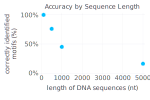

false

In [33]:
Gadfly.set_default_plot_size(15cm, 10cm)

myplot = Gadfly.plot(DataFrames.filter(Symbol("Test Name") => n -> n == "seqlen", df_toplot), 
    x=Symbol("Length of Sequences"), 
    y=Symbol("Percent Correct"),
    Gadfly.Geom.point,
    Gadfly.Scale.x_continuous(format = :plain),
    Gadfly.Scale.y_continuous(minvalue = 0, maxvalue = 1, labels = n -> "$(round(Int, 100n))%"), 
    Gadfly.Guide.xlabel("length of DNA sequences (nt)"),
    Gadfly.Guide.ylabel("correctly identified\nmotifs (%)", orientation =:vertical),
    Gadfly.Guide.title("Accuracy by Sequence Length"),
    Gadfly.style(major_label_font_size=18pt, minor_label_font_size=18pt, point_size = 6pt))

display(myplot)
draw(SVG("./figures/Figure_01.svg", 15cm, 10cm), myplot)

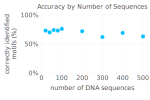

false

In [32]:
Gadfly.set_default_plot_size(15cm, 10cm)

myplot = Gadfly.plot(DataFrames.filter(Symbol("Test Name") => n -> n == "seqnum", df_toplot), 
    x=Symbol("Number of Sequences"), 
    y=Symbol("Percent Correct"),
    Gadfly.Geom.point,
    Gadfly.Scale.x_continuous(format = :plain),
    Gadfly.Scale.y_continuous(minvalue = 0, maxvalue = 1, labels = n -> "$(round(Int, 100n))%"), 
    Gadfly.Guide.xlabel("number of DNA sequences"),
    Gadfly.Guide.ylabel("correctly identified\nmotifs (%)", orientation =:vertical),
    Gadfly.Guide.title("Accuracy by Number of Sequences"),
    Gadfly.style(major_label_font_size=18pt, minor_label_font_size=18pt, point_size = 6pt))

display(myplot)
draw(SVG("./figures/Figure_02.svg", 15cm, 10cm), myplot)

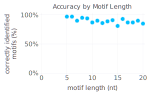

false

In [36]:
Gadfly.set_default_plot_size(15cm, 10cm)

myplot = Gadfly.plot(DataFrames.filter(Symbol("Test Name") => n -> n == "motiflen", df_toplot), 
    x=Symbol("Motif Length"), 
    y=Symbol("Percent Correct"),
    Gadfly.Geom.point,
    Gadfly.Scale.x_continuous(format = :plain),
    Gadfly.Scale.y_continuous(minvalue = 0, maxvalue = 1, labels = n -> "$(round(Int, 100n))%"), 
    Gadfly.Guide.xlabel("motif length (nt)"),
    Gadfly.Guide.ylabel("correctly identified\nmotifs (%)", orientation =:vertical),
    Gadfly.Guide.title("Accuracy by Motif Length"),
    Gadfly.style(major_label_font_size=18pt, minor_label_font_size=18pt, point_size = 6pt))

display(myplot)
draw(SVG("./figures/Figure_03.svg", 15cm, 10cm), myplot)

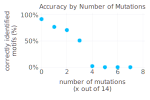

false

In [35]:
Gadfly.set_default_plot_size(15cm, 10cm)

myplot = Gadfly.plot(DataFrames.filter(Symbol("Test Name") => n -> n == "mutations", df_toplot), 
    x=Symbol("Number of Mutations"), 
    y=Symbol("Percent Correct"),
    Gadfly.Geom.point,
    Gadfly.Scale.x_continuous(format = :plain),
    Gadfly.Scale.y_continuous(minvalue = 0, maxvalue = 1, labels = n -> "$(round(Int, 100n))%"), 
    Gadfly.Guide.xlabel("number of mutations\n(x out of 14)"),
    Gadfly.Guide.ylabel("correctly identified\nmotifs (%)", orientation =:vertical),
    Gadfly.Guide.title("Accuracy by Number of Mutations"),
    Gadfly.style(major_label_font_size=18pt, minor_label_font_size=18pt, point_size = 6pt))

display(myplot)
draw(SVG("./figures/Figure_04.svg", 15cm, 10cm), myplot)

## run time/memory plots

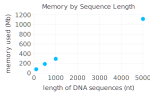

false

In [39]:
Gadfly.set_default_plot_size(15cm, 10cm)

myplot = Gadfly.plot(DataFrames.filter(Symbol("Test Name") => n -> n == "seqlen", df_toplot), 
    x=Symbol("Length of Sequences"), 
    y=Symbol("Memory (Mb)"),
    Gadfly.Geom.point,
    Gadfly.Scale.x_continuous(format = :plain),
    Gadfly.Scale.y_continuous(minvalue = 0, maxvalue = 1200), 
    Gadfly.Guide.xlabel("length of DNA sequences (nt)"),
    Gadfly.Guide.ylabel("memory used (Mb)", orientation =:vertical),
    Gadfly.Guide.title("Memory by Sequence Length"),
    Gadfly.style(major_label_font_size=18pt, minor_label_font_size=18pt, point_size = 6pt))

display(myplot)
draw(SVG("./figures/Figure_05_a.svg", 15cm, 10cm), myplot)

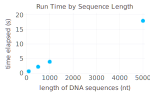

false

In [41]:
Gadfly.set_default_plot_size(15cm, 10cm)

myplot = Gadfly.plot(DataFrames.filter(Symbol("Test Name") => n -> n == "seqlen", df_toplot), 
    x=Symbol("Length of Sequences"), 
    y=Symbol("Time (s)"),
    Gadfly.Geom.point,
    Gadfly.Scale.x_continuous(format = :plain),
    Gadfly.Scale.y_continuous(minvalue = 0, maxvalue = 18), 
    Gadfly.Guide.xlabel("length of DNA sequences (nt)"),
    Gadfly.Guide.ylabel("time elapsed (s)", orientation =:vertical),
    Gadfly.Guide.title("Run Time by Sequence Length"),
    Gadfly.style(major_label_font_size=18pt, minor_label_font_size=18pt, point_size = 6pt))

display(myplot)
draw(SVG("./figures/Figure_05_b.svg", 15cm, 10cm), myplot)

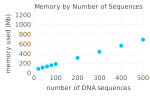

false

In [45]:
Gadfly.set_default_plot_size(15cm, 10cm)

myplot = Gadfly.plot(DataFrames.filter(Symbol("Test Name") => n -> n == "seqnum", df_toplot), 
    x=Symbol("Number of Sequences"),
    y=Symbol("Memory (Mb)"),
    Gadfly.Geom.point,
    Gadfly.Scale.x_continuous(format = :plain),
    Gadfly.Scale.y_continuous(minvalue = 0, maxvalue = 1200), 
    Gadfly.Guide.xlabel("number of DNA sequences"),
    Gadfly.Guide.ylabel("memory used (Mb)", orientation =:vertical),
    Gadfly.Guide.title("Memory by Number of Sequences"),
    Gadfly.style(major_label_font_size=18pt, minor_label_font_size=18pt, point_size = 6pt))

display(myplot)
draw(SVG("./figures/Figure_06_a.svg", 15cm, 10cm), myplot)

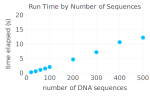

false

In [44]:
Gadfly.set_default_plot_size(15cm, 10cm)

myplot = Gadfly.plot(DataFrames.filter(Symbol("Test Name") => n -> n == "seqnum", df_toplot), 
    x=Symbol("Number of Sequences"),
    y=Symbol("Time (s)"),
    Gadfly.Geom.point,
    Gadfly.Scale.x_continuous(format = :plain),
    Gadfly.Scale.y_continuous(minvalue = 0, maxvalue = 18), 
    Gadfly.Guide.xlabel("number of DNA sequences"),
    Gadfly.Guide.ylabel("time elapsed (s)", orientation =:vertical),
    Gadfly.Guide.title("Run Time by Number of Sequences"),
    Gadfly.style(major_label_font_size=18pt, minor_label_font_size=18pt, point_size = 6pt))

display(myplot)
draw(SVG("./figures/Figure_06_b.svg", 15cm, 10cm), myplot)

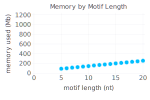

false

In [46]:
Gadfly.set_default_plot_size(15cm, 10cm)

myplot = Gadfly.plot(DataFrames.filter(Symbol("Test Name") => n -> n == "motiflen", df_toplot), 
    x=Symbol("Motif Length"), 
    y=Symbol("Memory (Mb)"),
    Gadfly.Geom.point,
    Gadfly.Scale.x_continuous(format = :plain),
    Gadfly.Scale.y_continuous(minvalue = 0, maxvalue = 1200), 
    Gadfly.Guide.xlabel("motif length (nt)"),
    Gadfly.Guide.ylabel("memory used (Mb)", orientation =:vertical),
    Gadfly.Guide.title("Memory by Motif Length"),
    Gadfly.style(major_label_font_size=18pt, minor_label_font_size=18pt, point_size = 6pt))

display(myplot)
draw(SVG("./figures/Figure_07_a.svg", 15cm, 10cm), myplot)


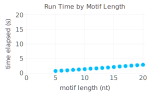

false

In [47]:
Gadfly.set_default_plot_size(15cm, 10cm)

myplot = Gadfly.plot(DataFrames.filter(Symbol("Test Name") => n -> n == "motiflen", df_toplot), 
    x=Symbol("Motif Length"), 
    y=Symbol("Time (s)"),
    Gadfly.Geom.point,
    Gadfly.Scale.x_continuous(format = :plain),
    Gadfly.Scale.y_continuous(minvalue = 0, maxvalue = 18), 
    Gadfly.Guide.xlabel("motif length (nt)"),
    Gadfly.Guide.ylabel("time elapsed (s)", orientation =:vertical),
    Gadfly.Guide.title("Run Time by Motif Length"),
    Gadfly.style(major_label_font_size=18pt, minor_label_font_size=18pt, point_size = 6pt))

display(myplot)
draw(SVG("./figures/Figure_07_b.svg", 15cm, 10cm), myplot)

## Benchmarking for Percent of Sequences Lacking Motif

In [53]:
"""
code recycled from gtb, HW2
"""
function runTrial_miss(l, d, seq_len, seq_num, percmiss) 
    # generate the simulated data
    motif, motif_starts, motifs_implanted, sequences = GenerateTestData_ld_somemissing(seq_num, l, seq_len, d, percmiss)
    
    test_score, test_motif = pso_motif(sequences, l, 5, 100, 100)

    return(Int(all(test_motif .== motif)))
end

runTrial_miss

In [54]:
"""
code recycled from gtb, HW2
"""
function benchmarker_miss(l, d, seq_len, seq_num, zz, pmiss)
    println(l, " ", d, " ", seq_len, " ", seq_num, " ", pmiss)
    res = permutedims(reduce(hcat, map(i -> [i for i in @timed(runTrial_miss(l, d, seq_len, seq_num, pmiss))[(:value, :time, :bytes)]], 1:zz)))
    return(StatsBase.mean(res; dims = 1))
end

benchmarker_miss

In [55]:
# iterate over motif length
Random.seed!(84768)
bm_miss_res = benchmarker_miss.((14,), (0,), (500,), (100,), (100,), [i/100 for i in 0:10:50])

14 0 500 100 0.0
14 0 500 100 0.1
14 0 500 100 0.2
14 0 500 100 0.3
14 0 500 100 0.4
14 0 500 100 0.5


6-element Vector{Matrix{Real}}:
 [0.9 2.243268174999999 1.8821317145e8]
 [0.87 2.184513896999999 1.8728086464e8]
 [0.81 2.1485854769999992 1.872317696e8]
 [0.77 2.176747867999999 1.872170624e8]
 [0.68 2.2422870410000004 1.8720290752e8]
 [0.71 2.1904184730000007 1.8715102784e8]

In [60]:
Random.seed!(54357)
bm_miss_res2 = benchmarker_miss.((14,), (0,), (500,), (100,), (100,), [i/100 for i in 60:10:90])

14 0 500 100 0.6
14 0 500 100 0.7
14 0 500 100 0.8
14 0 500 100 0.9


4-element Vector{Matrix{Real}}:
 [0.6 1.9622712390000006 1.8709748032e8]
 [0.32 1.972290837999999 1.8701685696e8]
 [0.09 1.977000189 1.8695936448e8]
 [0.06 1.968036807999999 1.8691339904e8]

In [70]:
df_miss_res = DataFrame(reduce(vcat, vcat(bm_miss_res, bm_miss_res2)), ["Percent Correct", "Time (s)", "Memory (Mb)"])

Row,Percent Correct,Time (s),Memory (Mb)
,Real,Real,Real
1,0.9,2.24327,1.88213e8
2,0.87,2.18451,1.87281e8
3,0.81,2.14859,1.87232e8
4,0.77,2.17675,1.87217e8
5,0.68,2.24229,1.87203e8
6,0.71,2.19042,1.87151e8
7,0.6,1.96227,1.87097e8
8,0.32,1.97229,1.87017e8
9,0.09,1.977,1.86959e8


In [71]:
df_miss_res[!,Symbol("Memory (Mb)")] .= df_miss_res[!,Symbol("Memory (Mb)")] ./ 1000000
insertcols!(df_miss_res, 1, Symbol("Test Name") => repeat(["nomotif"], 10))
insertcols!(df_miss_res, 1, Symbol("Motif Length") => repeat([14], 10))
insertcols!(df_miss_res, 1, Symbol("Number of Mutations") => repeat([0], 10))
insertcols!(df_miss_res, 1, Symbol("Length of Sequences") => repeat([500], 10))
insertcols!(df_miss_res, 1, Symbol("Number of Sequences") => repeat([100], 10))
insertcols!(df_miss_res, 1, Symbol("Number of Trials") => repeat([100], 10))
insertcols!(df_miss_res, 1, Symbol("Percent Sequences Missing Motif") => [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

Row,Percent Sequences Missing Motif,Number of Trials,Number of Sequences,Length of Sequences,Number of Mutations,Motif Length,Test Name,Percent Correct,Time (s),Memory (Mb)
,Float64,Int64,Int64,Int64,Int64,Int64,String,Real,Real,Float64
1,0.0,100,100,500,0,14,nomotif,0.9,2.24327,188.213
2,0.1,100,100,500,0,14,nomotif,0.87,2.18451,187.281
3,0.2,100,100,500,0,14,nomotif,0.81,2.14859,187.232
4,0.3,100,100,500,0,14,nomotif,0.77,2.17675,187.217
5,0.4,100,100,500,0,14,nomotif,0.68,2.24229,187.203
6,0.5,100,100,500,0,14,nomotif,0.71,2.19042,187.151
7,0.6,100,100,500,0,14,nomotif,0.6,1.96227,187.097
8,0.7,100,100,500,0,14,nomotif,0.32,1.97229,187.017
9,0.8,100,100,500,0,14,nomotif,0.09,1.977,186.959


In [72]:
# save the data
CSV.write("./benchmarking/test_results_nomotif.csv", df_miss_res)

"./benchmarking/test_results_nomotif.csv"

In [73]:
df_toplot2 = CSV.read("./benchmarking/test_results_nomotif.csv", DataFrame)

Row,Percent Sequences Missing Motif,Number of Trials,Number of Sequences,Length of Sequences,Number of Mutations,Motif Length,Test Name,Percent Correct,Time (s),Memory (Mb)
,Float64,Int64,Int64,Int64,Int64,Int64,String7,Float64,Float64,Float64
1,0.0,100,100,500,0,14,nomotif,0.9,2.24327,188.213
2,0.1,100,100,500,0,14,nomotif,0.87,2.18451,187.281
3,0.2,100,100,500,0,14,nomotif,0.81,2.14859,187.232
4,0.3,100,100,500,0,14,nomotif,0.77,2.17675,187.217
5,0.4,100,100,500,0,14,nomotif,0.68,2.24229,187.203
6,0.5,100,100,500,0,14,nomotif,0.71,2.19042,187.151
7,0.6,100,100,500,0,14,nomotif,0.6,1.96227,187.097
8,0.7,100,100,500,0,14,nomotif,0.32,1.97229,187.017
9,0.8,100,100,500,0,14,nomotif,0.09,1.977,186.959


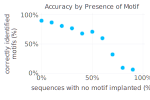

false

In [75]:
Gadfly.set_default_plot_size(15cm, 10cm)

myplot = Gadfly.plot(DataFrames.filter(Symbol("Test Name") => n -> n == "nomotif", df_toplot2), 
    x=Symbol("Percent Sequences Missing Motif"), 
    y=Symbol("Percent Correct"),
    Gadfly.Geom.point,
    Gadfly.Scale.x_continuous(minvalue = 0, maxvalue = 1, labels = n -> "$(round(Int, 100n))%"),
    Gadfly.Scale.y_continuous(minvalue = 0, maxvalue = 1, labels = n -> "$(round(Int, 100n))%"), 
    Gadfly.Guide.xlabel("sequences with no motif implanted (%)"),
    Gadfly.Guide.ylabel("correctly identified\nmotifs (%)", orientation =:vertical),
    Gadfly.Guide.title("Accuracy by Presence of Motif"),
    Gadfly.style(major_label_font_size=18pt, minor_label_font_size=18pt, point_size = 6pt))

display(myplot)
draw(SVG("./figures/Figure_09.svg", 15cm, 10cm), myplot)

## Compare to MEME
Meme commands:
```for i in $(ls /mnt/c/Users/grant/OneDrive/Documents/GitHub/CSC530_project/benchmarking/meme_test | sort -V); do /usr/bin/time -ao time.log -f "%e %M" ~/meme/bin/meme /mnt/c/Users/grant/OneDrive/Documents/GitHub/CSC530_project/benchmarking/meme_test/"$i" -dna -oc . -nostatus -time 14400 -mod oops -nmotifs 1 -minw 14 -maxw 14 -objfun classic -markov_order 0 -text | grep "^MOTIF " | awk '{print $2}' >> motifs.txt; done```

In [90]:
# generat the inputs for meme
seq_list = []
motif_list = []
Random.seed!(423134)
for i in 1:100
    this_correct_motif, this_motif_starts, this_motifs_implanted, this_sequences = GenerateTestData_ld(100, 14, 500, 2)
    append!(seq_list, [this_sequences])
    append!(motif_list, [this_correct_motif])
end

In [100]:
# write each of the sequences to a file
for i in 1:100
    fname = "./benchmarking/meme_test/test" * string(i) * ".fasta"
    open(fname, "w") do file1
        # for printing on the seqLogo website
        for j in 1:100
            println(file1, ">seq" * string(j))
            println(file1, join(seq_list[i][j]))
        end
    end
end

In [ ]:
# run the test using our algorithm
memevspso_pso = []
for i in 1:100
    this_outpt1, this_outpt2 = pso_motif(seq_list[i], 14, 5, 100, 100)
    append!(memevspso_pso, [this_outpt2])
end

In [109]:
# accuracu with PSO
sum(memevspso_pso .== motif_list) / 100

0.76

In [ ]:
# results from PSO
# accuracy (%)  time (s)   memory (Mb)
#         76%   2.15834      187.272

In [116]:
# read in the inputs from MEME
memevspso_meme = []
for line in readlines("C:/Users/grant/OneDrive/Documents/GitHub/CSC530_project/benchmarking/meme_test/motifs.txt")
    append!(memevspso_meme, [collect(line)])
end
# get the run times
memevspso_time = []
memevspso_memory = []
for line in readlines("C:/Users/grant/OneDrive/Documents/GitHub/CSC530_project/benchmarking/meme_test/time.log")
    # read in the parameters from the first line
    lines1 = parse.(Float64, split(line))
    append!(memevspso_time, lines1[1])
    append!(memevspso_memory, lines1[2]/1000)
end

In [121]:
sum(memevspso_time)/100

4.9098999999999995

In [122]:
sum(memevspso_memory)/100

12.671640000000009

In [124]:
sum(memevspso_meme .== motif_list)/100

1.0

In [127]:
# results from PSO
# accuracy (%)  time (s)   memory (Mb)
#         76%   2.15834      187.272

In [126]:
# results from MEME
# accuracy (%)  time (s)   memory (Mb)
#        100%       4.91         12.67

# Troubleshooting
This code was used to figure out whether the above programs were actually working.

# Memory Profiling

In [80]:
# set the seed
Random.seed!(101)
# use tuple unpacking to get some test values
# NumberOfSequences, LengthMotif, LengthSequences, Distance
correct_motif, motif_starts, motifs_implanted, sequences = GenerateTestData_ld(30, 10, 300, 0)

(motif = ['C', 'T', 'T', 'C', 'T', 'C', 'A', 'T', 'A', 'T'], motifs_starts = [199, 157, 110, 15, 240, 195, 25, 163, 197, 289  …  179, 96, 217, 103, 213, 227, 190, 224, 166, 177], motifs_implanted = [['C', 'T', 'T', 'C', 'T', 'C', 'A', 'T', 'A', 'T'], ['C', 'T', 'T', 'C', 'T', 'C', 'A', 'T', 'A', 'T'], ['C', 'T', 'T', 'C', 'T', 'C', 'A', 'T', 'A', 'T'], ['C', 'T', 'T', 'C', 'T', 'C', 'A', 'T', 'A', 'T'], ['C', 'T', 'T', 'C', 'T', 'C', 'A', 'T', 'A', 'T'], ['C', 'T', 'T', 'C', 'T', 'C', 'A', 'T', 'A', 'T'], ['C', 'T', 'T', 'C', 'T', 'C', 'A', 'T', 'A', 'T'], ['C', 'T', 'T', 'C', 'T', 'C', 'A', 'T', 'A', 'T'], ['C', 'T', 'T', 'C', 'T', 'C', 'A', 'T', 'A', 'T'], ['C', 'T', 'T', 'C', 'T', 'C', 'A', 'T', 'A', 'T']  …  ['C', 'T', 'T', 'C', 'T', 'C', 'A', 'T', 'A', 'T'], ['C', 'T', 'T', 'C', 'T', 'C', 'A', 'T', 'A', 'T'], ['C', 'T', 'T', 'C', 'T', 'C', 'A', 'T', 'A', 'T'], ['C', 'T', 'T', 'C', 'T', 'C', 'A', 'T', 'A', 'T'], ['C', 'T', 'T', 'C', 'T', 'C', 'A', 'T', 'A', 'T'], ['C', 'T', 'T', 'C

In [81]:
consensus_score(motifs_implanted, Dict('A' => 1/4, 'C' => 1/4, 'G' => 1/4, 'T' => 1/4))

(20.0, ['C', 'T', 'T', 'C', 'T', 'C', 'A', 'T', 'A', 'T'])

In [ ]:
using Profile
using PProf

In [ ]:
Profile.Allocs.clear()

In [ ]:
Profile.Allocs.@profile sample_rate=0.01 pso_motif(sequences, length(correct_motif), 1, 10, 10)

In [ ]:
PProf.Allocs.pprof(from_c=false)

In [ ]:
#Random.seed!(101)
BenchmarkTools.@btime pso_motif(sequences, length(correct_motif), 5, 100, 100)

In [ ]:
Random.seed!(101)
BenchmarkTools.@btime pso_motif(sequences, length(correct_motif), 1, 10, 10)

In [ ]:
BenchmarkTools.@btime pso_motif(sequences, length(correct_motif), 5, 100, 100)

In [ ]:
#pso_motif(sequences, length(correct_motif), 5, 100, 10)
# Random.seed!(105)
#pso_motif(sequences, length(correct_motif), 5, 50, 10)
# pso_motif(sequences, length(correct_motif), 5, 10, 10)
pso_motif(sequences, length(correct_motif), 5, 100, 100)

In [ ]:
StatProfilerHTML.@profilehtml pso_motif(sequences, length(correct_motif), 1, 10, 10)

In [82]:
StatProfilerHTML.@profilehtml pso_motif(sequences, length(correct_motif), 5, 100, 100)

┌ Info: Wrote profiling output to file://C:\Users\grant\OneDrive\Documents\GitHub\CSC530_project\statprof/index.html .
└ @ StatProfilerHTML C:\Users\grant\.julia\packages\StatProfilerHTML\xanrZ\src\StatProfilerHTML.jl:27


(Float16(19.75), ['C', 'T', 'T', 'C', 'T', 'C', 'A', 'T', 'A', 'T'])